In [ ]:
!pip install matplotlib
!pip install tensorflow

In [31]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [33]:
DATASET_PATH = "C:/Users/patil/Downloads/dataset/"

In [35]:
# Preprocessing function
def preprocess_image(image_path):
  
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image from {image_path}")
   
    # Original image
    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
   
    # Grayscale image
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayscale_image = cv2.resize(grayscale_image, (64, 64))
   
    # Preprocessed image
    preprocessed_image = grayscale_image / 255.0  # Normalize
    preprocessed_image = np.expand_dims(preprocessed_image, axis=-1)  # Add channel dimension

    return original_image, grayscale_image, preprocessed_image


In [38]:
# Data augmentation function
def augment_image(image):
      datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    image = np.expand_dims(image, axis=0)  # Add batch dimension
    augmented_images = [next(datagen.flow(image, batch_size=1))[0] for _ in range(3)]
    return augmented_images


IndentationError: unindent does not match any outer indentation level (<string>, line 14)

In [40]:
# Display images from the dataset
def display_dataset_images(dataset_path):
    """
    Display one image from each folder in the dataset with all preprocessing steps.
    """
    folders = os.listdir(dataset_path)
    total_images = len(folders) * 5  # 1 Original + 1 Grayscale + 1 Preprocessed + 3 Augmented
    plt.figure(figsize=(15, len(folders) * 5))  # Adjust the figure size for responsiveness
    print("Processing images...\n")
   
    for idx, folder in enumerate(folders):
        folder_path = os.path.join(dataset_path, folder)
        image_files = os.listdir(folder_path)
        
        if len(image_files) == 0:
            print(f"No images found in folder: {folder}")
            continue

        image_file = image_files[0]  # Take the first image from each folder
        image_path = os.path.join(folder_path, image_file)
        
        # Log the start of processing
        print(f"\nProcessing folder: {folder}")
        print(f"Loading image: {image_file}")
        
        # Preprocess the image
        original_image, grayscale_image, preprocessed_image = preprocess_image(image_path)
        
        # Log the processing steps
        print("Converting to grayscale and resizing...")
        print("Normalizing grayscale image and adding channel dimension...")
       
        # Augment preprocessed image
        augmented_images = augment_image(preprocessed_image)
       
        # Display original image
        plt.subplot(len(folders), 5, idx * 5 + 1)
        plt.imshow(original_image)
        plt.title(f"{folder}: Original")
        plt.axis("off")
       
        # Display grayscale image
        plt.subplot(len(folders), 5, idx * 5 + 2)
        plt.imshow(grayscale_image, cmap="gray")
        plt.title(f"{folder}: Grayscale")
        plt.axis("off")
       
        # Display preprocessed image
        plt.subplot(len(folders), 5, idx * 5 + 3)
        plt.imshow(preprocessed_image.squeeze(), cmap="gray")
        plt.title(f"{folder}: Preprocessed")
        plt.axis("off")
       
        # Display augmented images
        for aug_idx, aug_img in enumerate(augmented_images):
            subplot_index = idx * 5 + 4 + aug_idx  # Correct subplot index
            if subplot_index <= total_images:  # Ensure subplot index is valid
                plt.subplot(len(folders), 5, subplot_index)
                plt.imshow(aug_img.squeeze(), cmap="gray")
                plt.title(f"{folder}: Aug {aug_idx+1}")
                plt.axis("off")
                 
    plt.tight_layout()
    plt.show()


Processing images...


Processing folder: shashi_kapoor
Loading image: 031e25c6e2.jpg
Converting to grayscale and resizing...
Normalizing grayscale image and adding channel dimension...

Processing folder: shreyas_talpade
Loading image: 03ceced146.jpg
Converting to grayscale and resizing...
Normalizing grayscale image and adding channel dimension...

Processing folder: smita_patil
Loading image: 07cb71616a.jpg
Converting to grayscale and resizing...
Normalizing grayscale image and adding channel dimension...

Processing folder: soumitra_chatterjee
Loading image: 02faf009da.jpg
Converting to grayscale and resizing...
Normalizing grayscale image and adding channel dimension...

Processing folder: sridevi
Loading image: 00e83f8f66.jpg
Converting to grayscale and resizing...
Normalizing grayscale image and adding channel dimension...

Processing folder: sunil_shetty
Loading image: 03ef6ecabd.jpg
Converting to grayscale and resizing...
Normalizing grayscale image and adding channel dimensio

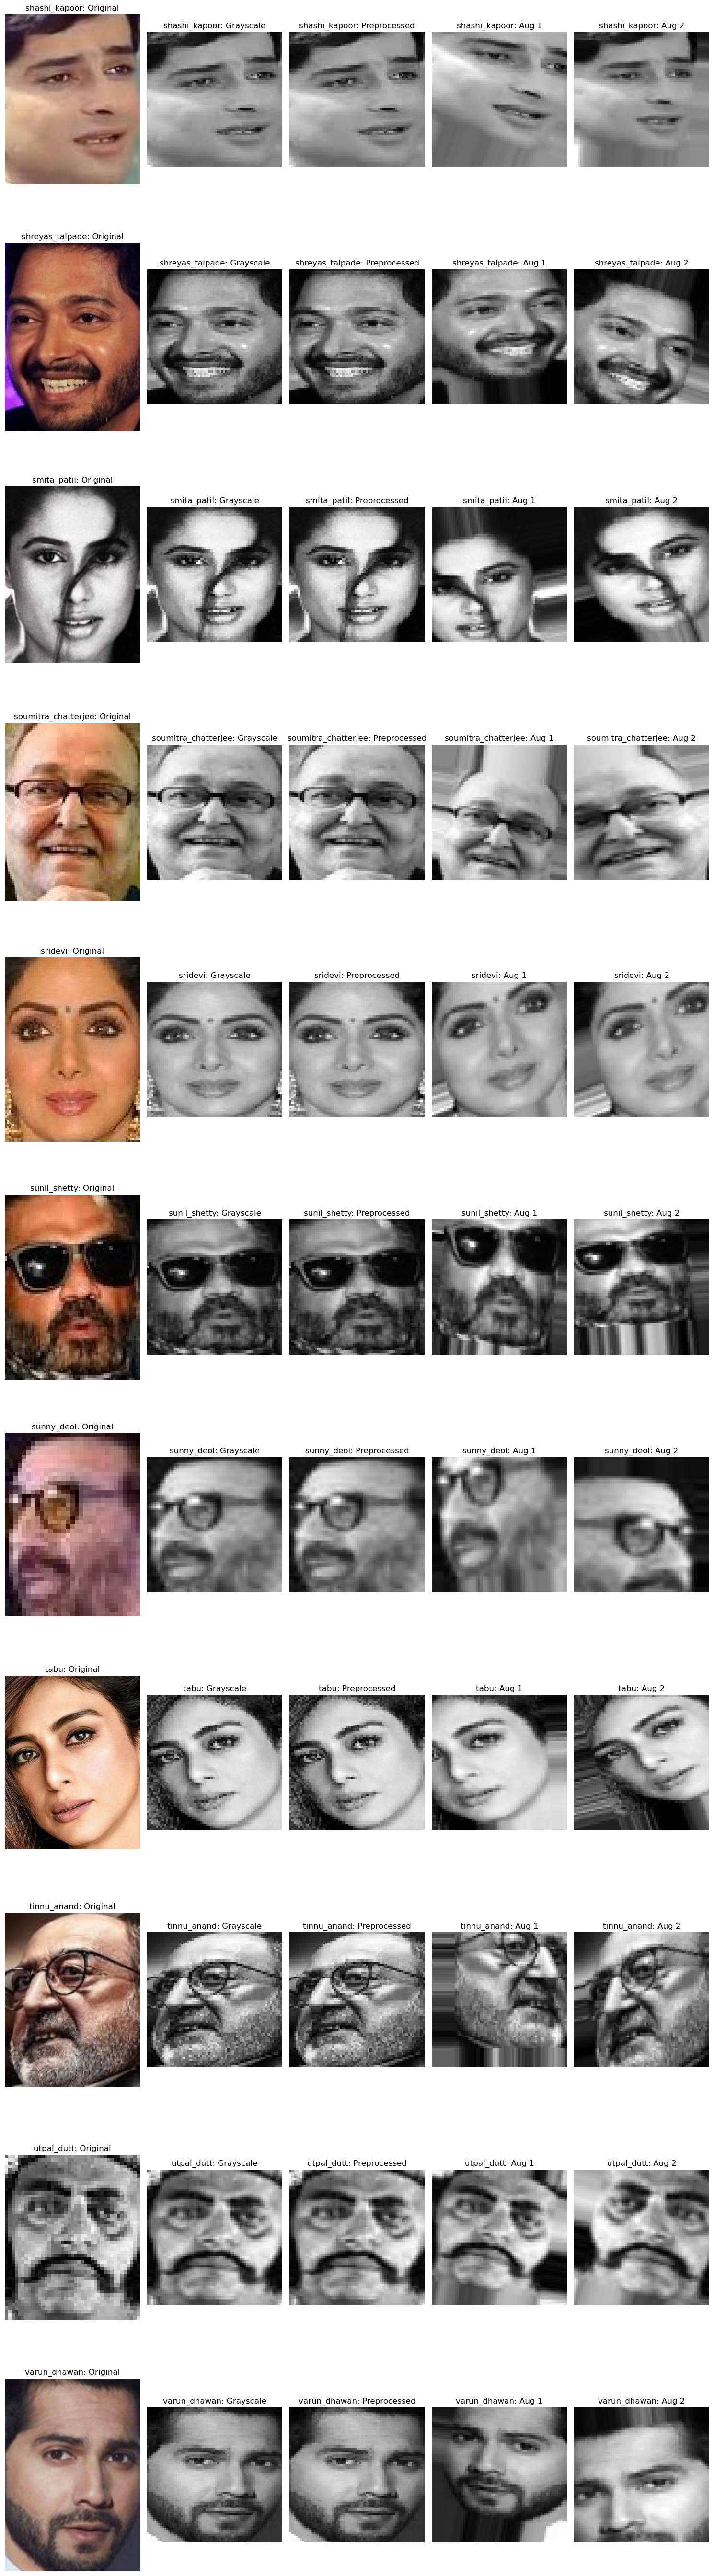

In [42]:
display_dataset_images(DATASET_PATH)

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from random import randint
from tensorflow.keras import Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Dataset Path
DATASET_PATH = "C:/Users/patil/Downloads/dataset/"

# Preprocessing Function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image from {image_path}")
    
    # Convert to grayscale and resize
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(grayscale_image, (64, 64))
    
    # Normalize the image
    preprocessed_image = resized_image / 255.0
    return preprocessed_image

# Load Dataset
def load_dataset(dataset_path):
    images, labels = [], []
    class_names = sorted(os.listdir(dataset_path))
    for label, class_name in enumerate(class_names):
        folder_path = os.path.join(dataset_path, class_name)
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            try:
                processed_image = preprocess_image(file_path)
                images.append(processed_image)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    return np.array(images), np.array(labels), class_names

# Load and preprocess dataset
X, y, class_names = load_dataset(DATASET_PATH)
X = X[..., np.newaxis]  # Add channel dimension for CNN
y = to_categorical(y, num_classes=len(class_names))  # One-hot encode labels

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# Use VGG16 as the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False 

# Add a custom classification head
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Updated CNN model definition
model = Sequential([
    Input(shape=(64, 64, 1)),  # Explicit input layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9),  # Gradient Descent
    loss='categorical_crossentropy',  # Add the loss function
    metrics=['accuracy']  # Include accuracy as a metric,
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,  # Adjust epochs based on requirement
    batch_size=16
)

# Callbacks for better training
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
]

# Train the model with callbacks
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=callbacks)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.argmax(axis=1)),  # Use class indices
    y=y_train.argmax(axis=1)  # Provide class indices, not one-hot encoded labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


# Plot training accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


# Visualize predictions on test set
def visualize_predictions(model, X_test, y_test, class_names):
    plt.figure(figsize=(15, 10))
    for i in range(5):  # Show 5 random test images
        idx = randint(0, len(X_test) - 1)
        image = X_test[idx]
        true_label = np.argmax(y_test[idx])
        predicted_label = np.argmax(model.predict(image[np.newaxis, ...]))

        # Plot the image and prediction
        plt.subplot(1, 5, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[predicted_label]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display predictions
visualize_predictions(model, X_test, y_test, class_names)

# Save the model in the native Keras format
model.save("wildlife_classifier.keras")
print("Model saved as 'wildlife_classifier.keras'")

Training samples: 392
Test samples: 98
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.0815 - loss: 2.4089 - val_accuracy: 0.1224 - val_loss: 2.3983
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1649 - loss: 2.3891 - val_accuracy: 0.0408 - val_loss: 2.4185
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.1327 - loss: 2.3664 - val_accuracy: 0.1939 - val_loss: 2.3613
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.2190 - loss: 2.3002 - val_accuracy: 0.2245 - val_loss: 2.1731
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.2698 - loss: 2.1064 - val_accuracy: 0.3980 - val_loss: 1.8820
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4067 - loss: 1.8448 - val_accuracy: 0.3878 - val_loss: 1.7031
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4617 - loss: 1.5217 - val_accuracy: 0.5816 - val_loss: 1.4489
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5994 - 